# CartPole using REINFORCE in PyTorch

In [ ]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [ ]:
env = gym.make("CartPole-v0")

## Creating the policy network

We will build and initialize a neural network that serves as a policy network. The policy network will accept state vectors as inputs, and it will produce a (discrete) probability distribution over the possible actions. You can think of the agent as a thin wrapper around the policy network that samples from the probability distribution to take an action. Remember, an agent in reinforcement learning is whatever function or algorithm takes a state and returns a concrete action that will be executed in the environment.

In [ ]:
l1 = 4
l2 = 150
l3 = 2

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0)
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- Input data is length 4
- The middle layer produces a vector of length 150
- Output is a 2-length vector for the Left and the Right actions
- The model is only two layers: a leaky ReLU activation function for the first layer, and the Softmax function for the last layer
- We chose the leaky ReLU because it performed better empirically
- Output is a softmax probability distribution over actions

## Having the agent interact with the environment

The agent consumes the state and takes an action, a, probabilistically. More specifically, the state is input to the policy network, which then produces the probability distribution over the actions $P(A|θ,S_t)$ given its current parameters and the state.

The policy network might return a discrete probability distribution in the form of a vector, such as [0.25, 0.75] for our two possible actions in CartPole. This means the policy network predicts that action 0 is the best with 25% probability, and action 1 is the best with 75% probability (or confidence). We call this array pred.

In [ ]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state2, reward, done, info = env.step(action)

- Call policy network model to produce predicted action probabilities
- Sample an action from the probability distribution produced by the policy network
- Take the action, receive new state and reward
- The info variable is produced by the environment but is irrelevant

The environment responds to the action by producing a new state, $s_2$, and a reward, $r_2$. We store those into two arrays (a states array and an actions array) for when we need to update our model after the episode ends. We then plug the new state into our model, get a new state and reward, store those, and repeat until the episode ends (the pole falls over and the game is finished).

## Training the model
We train the policy network by updating the parameters to minimize the objective (i.e., loss) function. This involves three steps:

- Calculate the probability of the action actually taken at each time step.
- Multiply the probability by the discounted return (the sum of rewards).
- Use this probability-weighted return to backpropagate and minimize the loss.

### Calculating the probability of the action

Calculating the probability of the action taken is easy enough. We can use the stored past transitions to recompute the probability distributions using the policy network, but this time we extract just the predicted probability for the action that was actually taken. We’ll denote this quantity $*P(a_t|θ,s_t)*$; this is a single probability value, like 0.75.

To be concrete, let’s say the current state is $*S_5*$ (the state at time step 5). We input that into the policy network and it returns $*P_θ(A|s_5)*$ = [0.25,0.75]. We sample from this distribution and take action $*a*$ = 1 (the second element in the action array), and after this the pole falls over and the episode has ended. The total duration of the episode was *T* = 5. For each of these 5 time steps, we took an action according to $*P_θ(A|s_t)*$ and we stored the specific probabilities of the actions that were actually taken, $*P_θ(a|s_t)*$, in an array, which might look like [0.5, 0.3, 0.25, 0.5, 0.75]. We simply multiply these probabilities by the discounted rewards (explained in the next section), take the sum, multiply it by –1, and call that our overall loss for this episode. Unlike Gridworld, in CartPole the last action is the one that loses the episode; we discount it the most since we want to penalize the worst move the most. In Gridworld we would do the opposite and discount the first action in the episode most, since it would be the least responsible for winning or losing.

Minimizing this objective function will tend to increase those probabilities $*P_θ(a|s_t)*$ weighted by the discounted rewards. So every episode we’re tending to increase $*P_θ(a|s_t)*$, but for a particularly long episode (if we’re doing well in the game and get a large end-of-episode return) we will increase the $*P_θ(a|s_t)*$ to a greater degree. Hence, on average over many episodes we will reinforce the actions that are good, and the bad actions will get left behind. Since probabilities must sum to 1, if we increase the probability of a good action, that will automatically steal probability mass from the other presumably less good actions. Without this redistributive nature of probabilities, this scheme wouldn’t work (i.e., everything both good and bad would tend to increase).

### Calculating future rewards

We multiply $*P(a_t|θ,s_t)*$ by the total reward (a.k.a. return) we received after this state. As mentioned earlier in the section, we can get the total reward by just summing the rewards (which is equal to the number of time steps the episode lasted in CartPole) and create a return array that starts with the episode duration and decrements by 1 until 1. If the episode lasted 5 time steps, the return array would be [5,4,3,2,1]. This makes sense because our first action should be rewarded the most, since it is the least responsible for the pole falling and losing the episode. In contrast, the action right before the pole fell is the worst action, and it should have the smallest reward. But this is a linear decrement—we want to discount the rewards exponentially.

To compute the discounted rewards, we make an array of $γ_t$ by taking our $γ$ parameter, which may be set to 0.99 for example, and exponentiating it according to the distance from the end of the episode. For example, we start with gamma_t = [0.99, 0.99, 0.99, 0.99, 0.99], then create another array of exponents exp = [1,2,3,4,5] and compute `torch.power(gamma_t, exp)`, which will give us [1.0, 0.99, 0.98, 0.97, 0.96].

### The loss function

Now that we have discounted returns, we can use these to compute the loss function to train the policy network. As we discussed previously, we make our loss function the negative log-probability of the action given the state, scaled by the reward returns. In PyTorch, this is defined as `-1 * torch.sum(r * torch.log(preds))`. We compute the loss with the data we’ve collected for the episode, and run the torch optimizer to minimize the loss. Let’s run through some actual code.

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    disc_return /= disc_return.max()
    return disc_return

- Compute exponentially decaying rewards
- Normalize the rewards to be within the [0,1] interval to improve numerical stability

Here we define a special function to compute the discounted rewards given an array of rewards that would look like [50,49,48,47,...] if the episode lasted 50 time steps. It essentially turns this linear sequence of rewards into an exponentially decaying sequence of rewards (e.g., [50.0000, 48.5100, 47.0448, 45.6041, ...]), and then it divides by the maximum value to bound the values in the interval [0,1].

The reason for this normalization step is to improve the learning efficiency and stability, since it keeps the return values within the same range no matter how big the raw return is. If the raw return is 50 in the beginning of training but then reaches 200 by the end of training, the gradients are going to change by almost an order of magnitude, which hampers stability. It will still work without normalization, but not as reliably.

In [ ]:
def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds))

- The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards
- It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign

## The REINFORCE training loop

Initialize, collect experiences, calculate the loss from those experiences, backpropagate, and repeat. The following listing defines the full training loop of our REINFORCE agent.

In [ ]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(MAX_DUR): #C
        act_prob = model(torch.from_numpy(curr_state).float()) #D
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #F
        transitions.append((prev_state, action, t+1)) #G
        if done: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

- `A` List to keep track of the episode length over training time
- `B` List of state, action, rewards (but we ignore the reward)
- `C` While in episode
- `D` Get the action probabilities
- `E` Select an action stochastically
- `F` Take the action in the environment
- `G` Store this transition
- `H` If game is lost, break out of the loop
- `I` Store the episode length
- `J` Collect all the rewards in the episode in a single tensor
- `K` Compute the discounted version of the rewards
- `L` Collect the states in the episode in a single tensor
- `M` Collect the actions in the episode in a single tensor
- `N` Re-compute the action probabilities for all the states in the episode
- `O` Subset the action-probabilities associated with the actions that were actually taken 

In [ ]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score, 50)

We start an episode, use the policy network to take actions, and record the states and actions we observe. Then, once we break out of an episode, we have to recompute the predicted probabilities to use in our loss function. Since we record all the transitions in each episode as a list of tuples, once we’re out of the episode we can separate each component of each transition (the state, action, and reward) into separate tensors to train on a batch of data at a time. If you run this code, you should be able to plot the episode duration against the episode number, and you will hopefully see a nicely increasing trend.

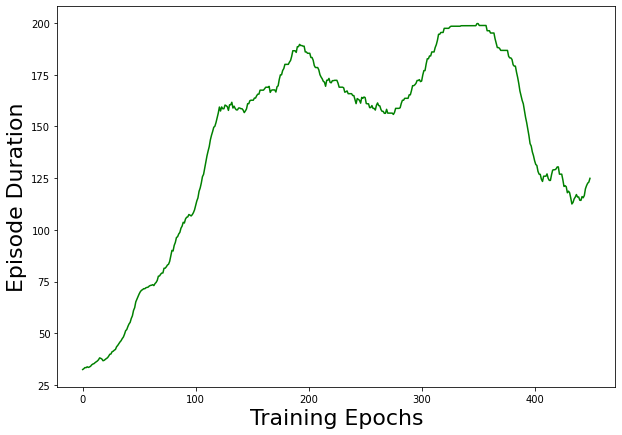

In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')
plt.show()

*After training the policy network to 500 epochs, we get a plot that demonstrates the agent really is learning how to play CartPole. Note that this is a moving average plot with a window of 50 to smooth the plot.*

The agent learns how to play CartPole! The nice thing about this example is that it should be able to train in under a minute on your laptop with just the CPU. The state of CartPole is just a 4-dimensional vector, and our policy network is only two small layers, so it’s much faster to train than the DQN we created to play Gridworld. OpenAI’s documentation says that the game is considered “solved” if the agent can play an episode beyond 200 time steps. Although the plot looks like it tops off at around 190, that’s because it’s a moving average plot. There are many episodes that reach 200 but a few times where it randomly fails early on, bringing the average down a bit. Also, we capped the episode duration at 200, so if you increase the cap it will be able to play even longer.

REINFORCE is an effective and very simple way of training a policy function, but it’s a little too simple. For CartPole it works very well, since the state space is very small and there are only two actions. If we’re dealing with an environment with many more possible actions, reinforcing all of them each episode and hoping that on average it will only reinforce the good actions becomes less and less reliable.